# Sementic segmentation of flair1 data with a basic UNet

In [49]:
# import all the necessary modules
import matplotlib.pyplot as plt
import rasterio
from pathlib import Path
from utils import *
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from pathlib import Path
import random
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

## Prepare the data
1) Download the data and split it into training, validation and test sets
2) Create a Dataloader
3) Load the data

In [39]:
dict_classes = {
1   : 'building',
2   : 'pervious surface',
3   : 'impervious surface',
4   : 'bare soil',
5   : 'water',
6   : 'coniferous',
7   : 'deciduous',
8   : 'brushwood',
9   : 'vineyard',
10  : 'herbaceous vegetation',
11  : 'agricultural land',
12  : 'plowed land',
13  : 'swimming_pool',
14  : 'snow',
15  : 'clear cut',
16  : 'mixed',
17  : 'ligneous',
18  : 'greenhouse',
19  : 'other'}

colors = {
1   : '#db0e9a',
2   : '#938e7b',
3   : '#f80c00',
4   : '#a97101',
5   : '#1553ae',
6   : '#194a26',
7   : '#46e483',
8   : '#f3a60d',
9   : '#660082',
10  : '#55ff00',
11  : '#fff30d',
12  : '#e4df7c',
13  : '#3de6eb',
14  : '#ffffff',
15  : '#8ab3a0',
16  : '#6b714f',
17  : '#c5dc42',
18  : '#9999ff',
19  : '#000000'}

images = sorted(list(get_data_paths(Path(folder_path), 'IMG*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))[0:100]
masks  = sorted(list(get_data_paths(Path(folder_path), 'MSK*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))[0:100]

#split into train, validation and test
images_train, images_test = train_test_split(images, test_size=0.2, random_state=42)
masks_train, masks_test = train_test_split(masks, test_size=0.2, random_state=42)
images_train, images_val = train_test_split(images_train, test_size=0.2, random_state=42)
masks_train, masks_val = train_test_split(masks_train, test_size=0.2, random_state=42)

In [50]:
class Flair1Dataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, split="all", seed = 42):
        super(Flair1Dataset, self).__init__()
        self.folder_path = folder_path
        self.split = split
        self.img_files = sorted(list(get_data_paths(Path(self.folder_path), 'IMG*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
        self.mask_files = sorted(list(get_data_paths(Path(self.folder_path), 'MSK*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
        self.total = len(self.img_files)
        random.seed(seed)  # For reproducibility
        shuffled_indices = list(range(self.total))
        random.shuffle(shuffled_indices)
        train_size = int(0.6 * self.total)  # 60% for training
        test_valid_size = self.total - train_size  # 40% for testing and validation
        valid_size = int(0.5 * test_valid_size)  # Half of the remaining 40% for validation
        if split =='all':
            self.indices = shuffled_indices
        elif split == "train":
            self.indices = shuffled_indices[:train_size]
        elif split == "valid":
            self.indices = shuffled_indices[train_size:train_size+valid_size]
        elif split == "test":
            self.indices = shuffled_indices[train_size+valid_size:]
        elif split == "toy":
            self.indices = shuffled_indices[:100]
        else:
            raise ValueError("Invalid split. Choose 'all' 'train', 'valid' or 'test'.")
        self.img_files = [self.img_files[i] for i in self.indices]
        self.mask_files = [self.mask_files[i] for i in self.indices]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = self.mask_files[idx]
        data = rasterio.open(img_path).read()
        label = rasterio.open(mask_path).read()
        if data.shape[0] > 3:
            data = data[:3, :, :]
        return torch.from_numpy(data).int(), torch.from_numpy(label).int()

In [32]:
folder_path = '../../data/flair1/'

train_ds = Flair1Dataset(folder_path, split="train")
val_ds = Flair1Dataset(folder_path, split="valid")
test_ds = Flair1Dataset(folder_path, split="test")

In [33]:
batch_size = 32
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)

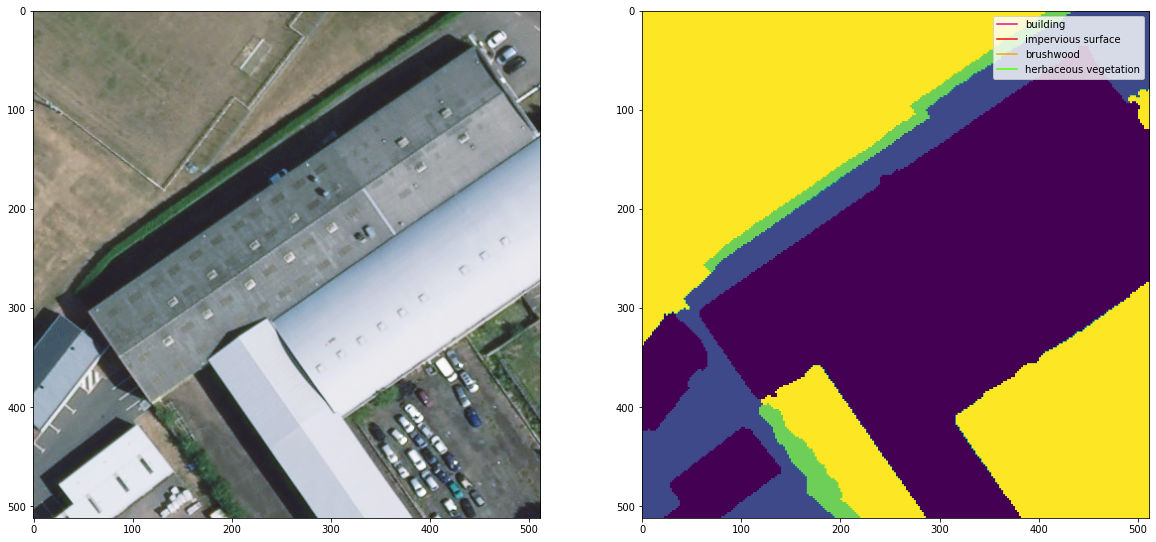

In [47]:
img, msk = next(iter(train_dl))
plot_image_mask_2(img[0], msk[0])

## Create the model

In [52]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


## Create the functions for training, validation and test, with plots of the loss

In [ ]:
#def train and store losses and accuracies
def train(model, train_dl, val_dl, loss_fn, optimizer, epochs=1, device="cpu"):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []
    for epoch in range(epochs):
        model.train()
        batch_loss, batch_acc = [], []
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            y_pred = model(xb)
            loss = loss_fn(y_pred, yb)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
            batch_acc.append(accuracy(y_pred, yb))
        train_loss.append(np.mean(batch_loss))
        train_acc.append(np.mean(batch_acc))
        model.eval()
        with torch.no_grad():
            batch_loss, batch_acc = [], []
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                y_pred = model(xb)
                loss = loss_fn(y_pred, yb)
                batch_loss.append(loss.item())
                batch_acc.append(accuracy(y_pred, yb))
            val_loss.append(np.mean(batch_loss))
            val_acc.append(np.mean(batch_acc))
        print(
            "Epoch %s, train loss: %.2f, val loss: %.2f, train acc: %.2f, val acc: %.2f"
            % (epoch, train_loss[-1], val_loss[-1], train_acc[-1], val_acc[-1])
        )
    return train_loss, val_loss, train_acc, val_acc

#def accuracy
def accuracy():

## Run the algorithm for a tiny subset

In [51]:
toy_ds = Flair1Dataset(folder_path, split="toy")
toy_dl = torch.utils.data.DataLoader(toy_ds, batch_size=batch_size, shuffle=True)